In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
sns.set_context('paper', font_scale=1.5)

heatmap_cmap = 'GnBu'

import scipy
from scipy.stats import ttest_rel, beta, ttest_ind
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np
import os
import yaml
import shutil
from collections import OrderedDict

from utils import quick_load_experiments_tsv, get_significance_by_column, add_probing_location_better_column
from common import lang2code, code2lang, lang2family, family2langs, lang2large_family

figure_dir = "fig/typology"
os.makedirs("fig", exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

np.random.seed(2)

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Load data

In [3]:
exps = pd.read_table("../dataframes/all_experiments.tsv", sep="\t", quoting=3)
exps['tag'] = exps['task'].apply(lambda t: t.split("_")[0])
exps['pos'] = exps['task'].apply(lambda t: t.split("_")[1])
exps['full_task'] = exps['language'] + ' ' + exps['task']
exps['family'] = exps['language'].apply(lambda l: lang2family[l])

exps = add_probing_location_better_column(exps)

In [4]:
fertility = pd.read_table("../dataframes/task_fertility.tsv")
old_len = len(exps)

exps = exps.merge(fertility, on=['language', 'task'], how='inner')

if old_len != len(exps):
    raise ValueError(f"Merging with fertility dataframe changed the number of rows: {old_len} --> {len(exps)}")

# Perturbations

In [5]:
data_perturbations = ['TARG', 'L$_2$', 'R$_2$', 'B$_2$', 'permute']
model_perturbations = [
    'mBERT-char',
    'mBERT-rand-subw', 
    'mBERT-rand-char',
    'mBERT-emb',
    'mBERT-nocontext',
    'prev',
    'next'
]
baseline_models = ['chLSTM', 'chLSTM-rand', 'swLSTM', 'fastText']

# Test effect

$$
\text{Effect}(p, t) = 100(1 - \frac{\text{Acc}(p, t)}{\text{Acc}(t)})
$$

In [6]:
bert_exps = exps[
    (exps.model=='mBERT') &
    (exps.probing_location_better==True)
]

bert_exps.shape

(4147, 24)

In [7]:
bert_exps.groupby(['language', 'task', 'perturbation'], dropna=False).size().value_counts()

1    4147
dtype: int64

In [8]:
unperturbed = bert_exps[bert_exps.perturbation.isnull()]
unperturbed = unperturbed.set_index(['language', 'task']).test_acc

In [9]:
perturbed = bert_exps[bert_exps.perturbation.isin(model_perturbations + data_perturbations)].pivot_table(
    index=['language', 'task'], columns='perturbation', values='test_acc'
)

In [10]:
test_effect = 100 * (1 - perturbed / unperturbed.values[:, None])

In [11]:
test_effect.mean()

perturbation
B$_2$               3.967901
L$_2$               1.745740
R$_2$               1.104947
TARG               17.257624
mBERT-char          8.630957
mBERT-emb          11.805716
mBERT-nocontext     6.910925
mBERT-rand-char    39.762621
mBERT-rand-subw    38.198294
next               12.598941
permute             5.516028
prev                8.537573
dtype: float64

# Linguistic typology

## Logistic regression (classification) using WALS features

In [12]:
areas = pd.read_csv("../dataframes/wals/wals_areas.tsv", sep="\t")
feat2area = dict(areas[['Name', 'Area']].drop_duplicates().values)
feat2area['Family'] = 'Family'

wals_languages = []
wals = []
param2area = {}
for fn in os.listdir('../dataframes/wals'):
    if not fn.endswith('csv'):
        continue
    lang = fn.split(".")[0]
    wals_languages.append(lang)
    df = pd.read_csv(f"../dataframes/wals/{lang}.csv", encoding='latin1')
    df = df.sort_values('Parameter').pivot(index='Language', columns='Parameter', values='Name')
    wals.append(df)
    
wals = pd.concat(wals, sort=True)
wals.index = wals_languages
wals.loc['Latin'] = np.nan 
wals['Family'] = wals.index.map(lambda l: lang2family[l])
print(wals.shape), wals.isnull().stack().mean()
wals

(39, 177)


<ipython-input-12-1ee5a8b68884>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  wals['Family'] = wals.index.map(lambda l: lang2family[l])


Parameter,'Want' Complement Subjects,'When' Clauses,Absence of Common Consonants,Action Nominal Constructions,Adjectives without Nouns,Alignment of Case Marking of Full Noun Phrases,Alignment of Case Marking of Pronouns,Alignment of Verbal Person Marking,Antipassive Constructions,Applicative Constructions,...,Verbal Person Marking,Voicing and Gaps in Plosive Systems,Voicing in Plosives and Fricatives,Vowel Nasalization,Vowel Quality Inventories,Weight Factors in Weight-Sensitive Stress Systems,Weight-Sensitive Stress,Zero Copula for Predicate Nominals,Zero Marking of A and P Arguments,Family
Danish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Long vowel or coda consonant,Combined: Right-edge and unbounded,NaN,NaN,Germanic
Lithuanian,NaN,NaN,All present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,None missing in /p t k b d g/,In both plosives and fricatives,NaN,Average (5-6),Lexical stress,Unbounded: Stress can be anywhere,Possible,NaN,Baltic
Swedish,NaN,NaN,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Long vowel or coda consonant,Right-oriented: One of the last three,Impossible,NaN,Germanic
Catalan,NaN,NaN,All present,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,None missing in /p t k b d g/,In both plosives and fricatives,NaN,Large (7-14),Lexical stress,Right-edge: Ultimate or penultimate,NaN,NaN,Romance
Italian,NaN,Balanced/deranked,NaN,NaN,NaN,NaN,NaN,Accusative,NaN,NaN,...,Only the A argument,NaN,NaN,NaN,NaN,Lexical stress,Right-edge: Ultimate or penultimate,NaN,NaN,Romance
Urdu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Indic
English,Subject is left implicit,Balanced/deranked,All present,Mixed,Marked by following word,Neutral,Nominative - accusative (standard),Accusative,No antipassive,No applicative construction,...,Only the A argument,None missing in /p t k b d g/,In both plosives and fricatives,Contrast absent,Large (7-14),Long vowel or coda consonant,Right-oriented: One of the last three,Impossible,Non-zero marking,Germanic
Dutch,NaN,NaN,NaN,Ergative-Possessive,NaN,NaN,NaN,Accusative,NaN,NaN,...,Only the A argument,NaN,NaN,NaN,NaN,Coda consonant,Right-oriented: One of the last three,Impossible,NaN,Germanic
Armenian,NaN,NaN,All present,Possessive-Accusative,NaN,Nominative - accusative (standard),Nominative - accusative (standard),Accusative,No antipassive,No applicative construction,...,Only the A argument,Other,In fricatives alone,Contrast absent,Average (5-6),Prominence,Unbounded: Stress can be anywhere,Impossible,NaN,Armenian
Afrikaans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Germanic


In [34]:
te = test_effect[model_perturbations + data_perturbations].copy()
te['HAS_TASK'] = 1
logreg_perts = te.columns
te = te.unstack()
te = te.fillna(0)
te['HAS_TASK'] = te['HAS_TASK'].fillna(0)

In [36]:
lin_acc = []
K = 3

for col in wals.columns:
    target = wals[col].dropna()
    common = sorted(set(target.index) & set(te.index))
    label_cnt = target.value_counts()
    large_classes = label_cnt[label_cnt>=K]
    if len(large_classes) < 2:
        continue
    target = target[target.isin(large_classes.index)]
    if target.value_counts(normalize=True).max() > 0.8:
         continue
    if len(label_cnt) < 2:
        continue
    te_common = te.loc[target.index]
    for pert in logreg_perts:
        X = te_common[pert]
        score = cross_val_score(
            LogisticRegression(solver='liblinear', multi_class='auto', max_iter=200),
            X, target, cv=3, scoring='f1_macro')
        notnull = len(target)
        lin_acc.append({
            'perturbation': pert, 'feature': col, 'score': score.mean(),
            'notnull': notnull, 'labels': dict(target.value_counts())})
    X = te_common
    score = cross_val_score(LogisticRegression(
        solver='liblinear', multi_class='auto', max_iter=200), X, target, cv=3, scoring='f1_macro')
    notnull = len(target)
    lin_acc.append({'perturbation': 'ALL', 'feature': col, 'score': score.mean(),
                    'notnull': notnull, 'labels': dict(target.value_counts())})
lin_acc = pd.DataFrame(lin_acc)


In [16]:
pd.set_option('display.max_rows', 500)
l = lin_acc.sort_values('score', ascending=False).copy()

In [17]:
l.perturbation = l.perturbation.str.replace('$', '')
l['Area'] = l.feature.apply(lambda l: feat2area[l])
l.head(15)

<ipython-input-17-e67e3aea058d>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  l.perturbation = l.perturbation.str.replace('$', '')


,perturbation,feature,score,notnull,labels,Area
99,mBERT-rand-subw,Conjunctions and Universal Quantifiers,1.000000,10,"{'Formally similar, without interrogative': 5,...",Nominal Categories
1109,mBERT-emb,The Position of Negative Morphemes in SOV Lang...,1.000000,6,"{'SONegV': 3, 'More than one construction': 3}",Word Order
806,L_2,Reason Clauses,0.933333,14,"{'Balanced/deranked': 9, 'Balanced': 5}",Complex Sentences
1029,TARG,Systems of Gender Assignment,0.933333,15,"{'Semantic and formal': 9, 'No gender': 6}",Nominal Categories
930,next,Sex-based and Non-sex-based Gender Systems,0.920635,16,"{'Sex-based': 10, 'No gender': 6}",Nominal Categories
825,ALL,Reciprocal Constructions,0.920635,15,"{'Mixed': 9, 'Distinct from reflexive': 6}",Simple Clauses
1027,prev,Systems of Gender Assignment,0.920635,15,"{'Semantic and formal': 9, 'No gender': 6}",Nominal Categories
1028,next,Systems of Gender Assignment,0.920635,15,"{'Semantic and formal': 9, 'No gender': 6}",Nominal Categories
107,R_2,Conjunctions and Universal Quantifiers,0.911111,10,"{'Formally similar, without interrogative': 5,...",Nominal Categories
703,mBERT-emb,Position of Interrogative Phrases in Content Q...,0.892857,26,"{'Initial interrogative phrase': 18, 'Not init...",Word Order


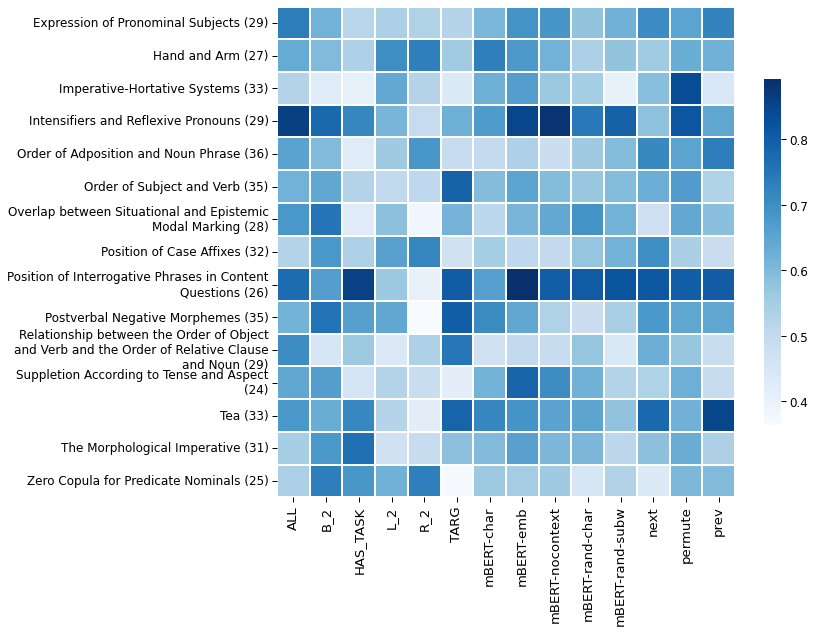

In [18]:
features = set(l[l['notnull']>=20].groupby('feature').score.mean().sort_values(ascending=False).head(15).index)

def wrap_text(text, maxline=40):
    lines = []
    this_line = []
    for word in text.split(" "):
        this_line.append(word)
        if sum(len(w) + 1 for w in this_line) - 1 >= maxline:
            lines.append(" ".join(this_line))
            this_line = []
    if this_line:
        lines.append(" ".join(this_line))
    return "\n".join(lines)
        
def plot_wals_pert_heatmap(data, save_fn=None, title=None):
    notnull = data[['feature', 'notnull']].drop_duplicates().set_index('feature')['notnull']
    table = data.pivot(index='feature', columns='perturbation', values='score')
    ysize = max(len(table), 6)
    max_text_len = data['feature'].str.len().max()
    scale = 'small' if max_text_len >= 85 else 'large'
    with matplotlib.rc_context(rc={'ytick.labelsize': 'large'}):
        fig, ax = plt.subplots(1, figsize=(12, 8))
        sns.heatmap(table, cmap='Blues', ax=ax, linewidth=.1, square=True, cbar_kws={'shrink': 0.7})
        ticks = []
        for tick in ax.get_yticklabels():
            t = tick.get_text()
            t = "{} ({})".format(t, notnull.loc[t])
            tick.set_text(wrap_text(t))
            ticks.append(tick)
        ax.set_yticklabels(ticks)
        ax.set_ylabel("")
        ax.set_xlabel("")
        plt.subplots_adjust(left=0.5)
        plt.tight_layout()
        if title:
            ax.set_title(title)
        if save_fn:
            fig.savefig(save_fn)
plot_wals_pert_heatmap(l[l.feature.isin(features)], save_fn=f"{figure_dir}/heatmap_wals_logreg.png")

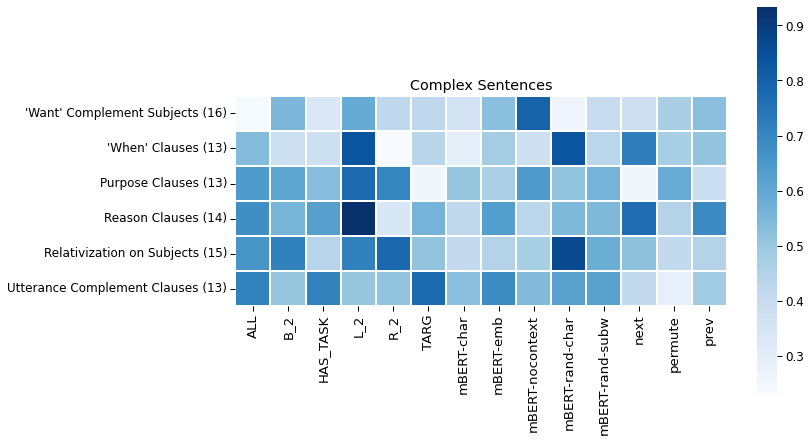

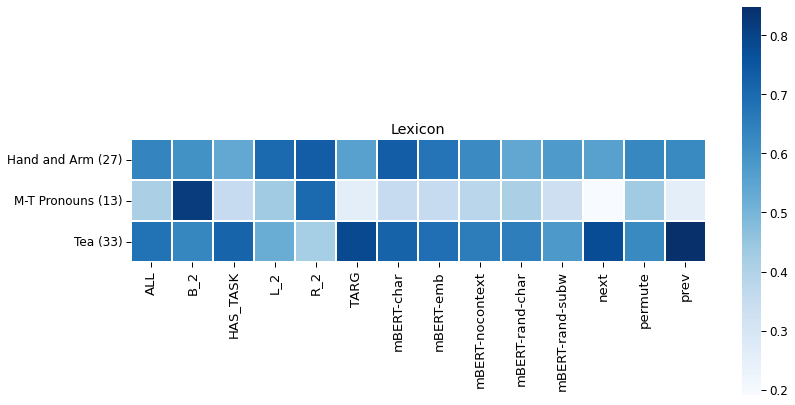

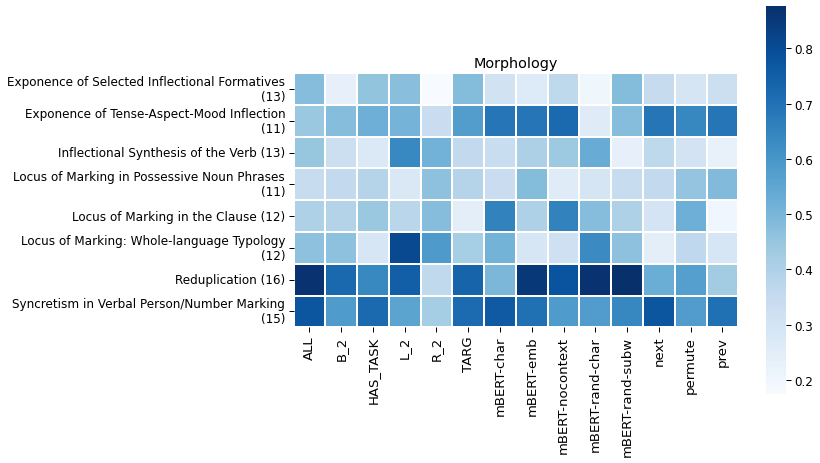

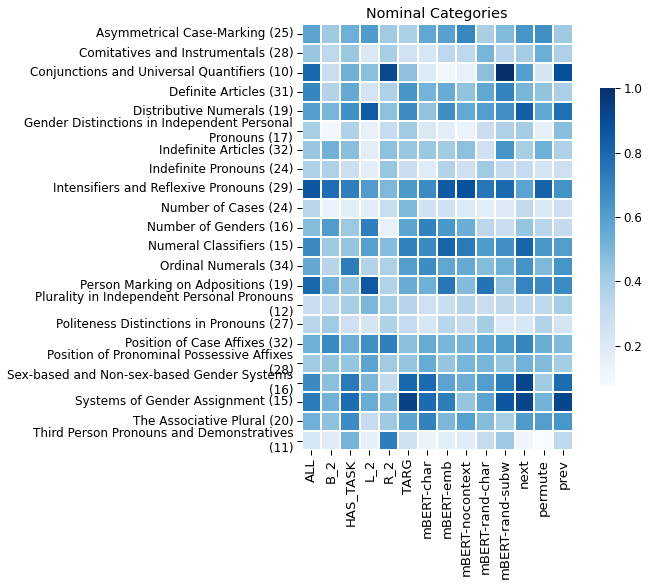

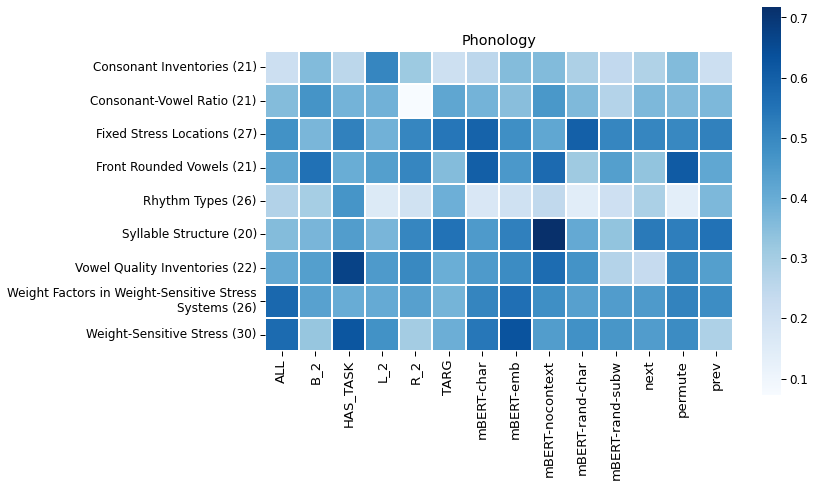

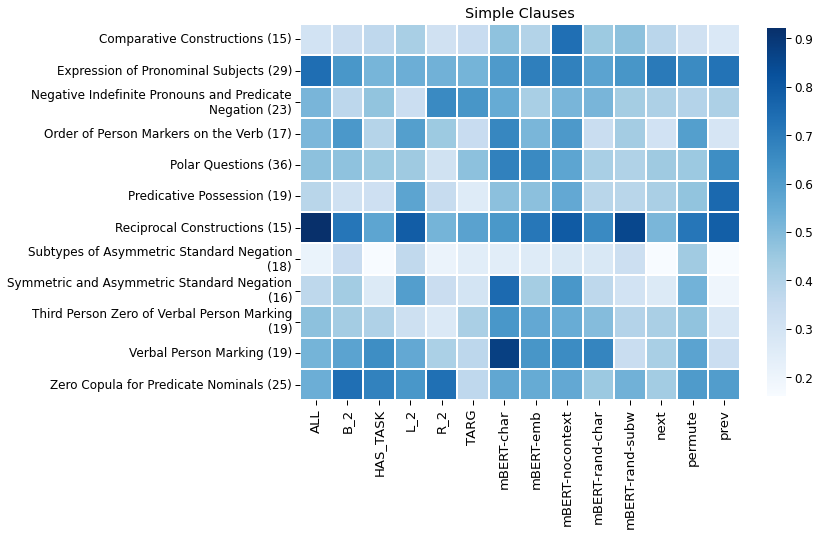

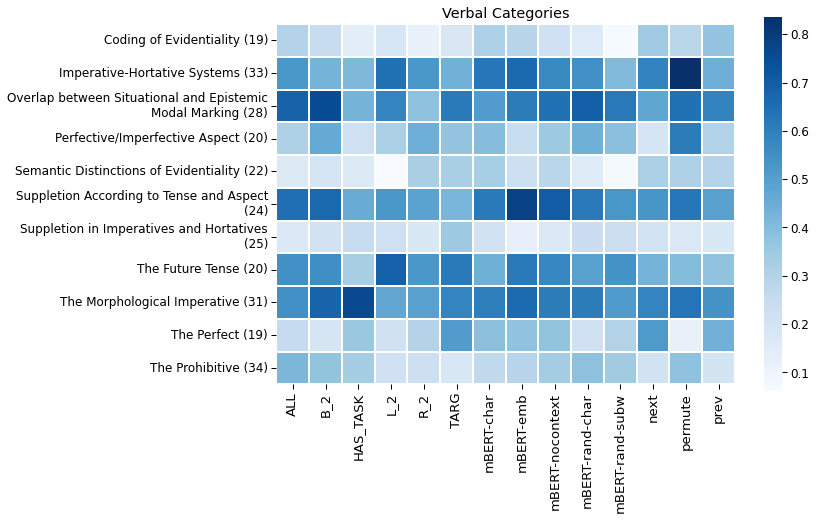

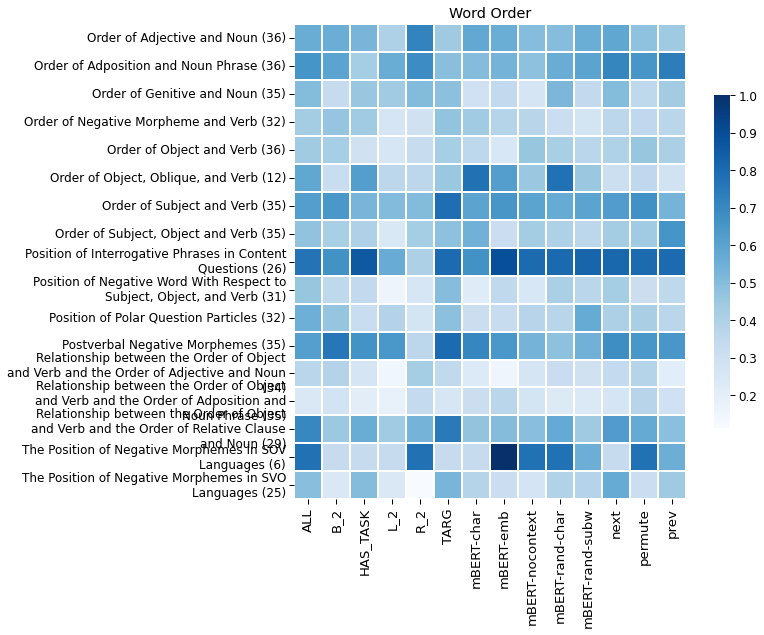

In [19]:
for area, group in l.groupby('Area'):
    if group.feature.nunique() < 2:
        continue
    area_name = area.replace(' ', '_').lower()
    plot_wals_pert_heatmap(group, title=area, save_fn=f"{figure_dir}/heatmap_wals_{area_name}.png")

## Linear regression weights

Target: effect of each perturbations

In [20]:
lin_acc = []
K = 3

linreg_scores = []

for pert in model_perturbations + data_perturbations:
    target = test_effect[pert].mean(level=0)
    target = target.drop('Latin')
    features = pd.get_dummies(wals.drop('Latin').fillna('Nan'))
    score = cross_val_score(
        SVR(),
        features, target, cv=3, scoring='neg_root_mean_squared_error')
    linreg_scores.append({'perturbation': pert, 'score': score.mean()})
linreg_scores = pd.DataFrame(linreg_scores)

<ipython-input-20-b7a307d573d0>:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
<ipython-input-20-b7a307d573d0>:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
<ipython-input-20-b7a307d573d0>:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  target = test_effect[pert].mean(level=0)
<ipython-input-20-b7a307d573d0>:7: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and w

In [21]:
linreg_scores

,perturbation,score
0,mBERT-char,-4.219169
1,mBERT-rand-subw,-8.019166
2,mBERT-rand-char,-10.044770
3,mBERT-emb,-6.057694
4,mBERT-nocontext,-5.243650
5,prev,-3.176493
6,next,-4.541787
7,TARG,-7.996736
8,L$_2$,-1.373075
9,R$_2$,-2.574491


## Family aggregated mean/std

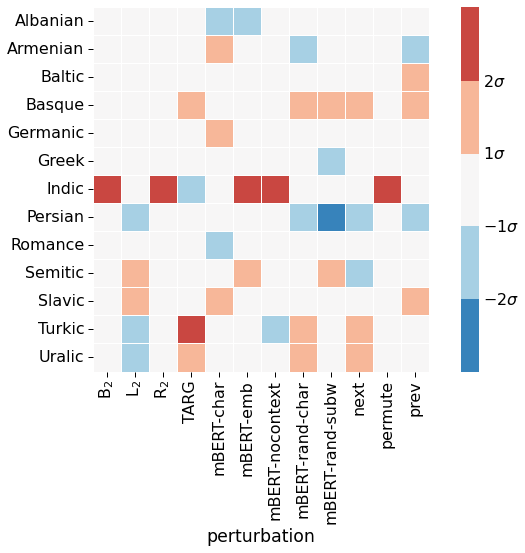

In [22]:
te = test_effect.reset_index()
te['family'] = te.language.apply(lambda l: lang2family[l])
te = te.groupby('family').mean()
te_std = te.std()
te_mean = te.mean()

te_discrete = pd.cut(((te - te_mean) / te_std).stack(), bins=[-1000, -2, -1, 1, 2, 1000], labels=[-2, -1, 0, 1, 2]).unstack().astype(int)
te_discrete
with sns.plotting_context('paper', font_scale=1.8):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    sns.heatmap(te_discrete, ax=ax, cmap=sns.color_palette('RdBu_r', 5),
                linewidths=.5, vmin=-2, vmax=2, center=0, square=True)
    ax.set_ylabel("")
    colorbar = ax.collections[0].colorbar
    #colorbar.ax.set_frame_on(True)
    colorbar.ax.tick_params(size=0)
    ticklabels = [
        "$-2\sigma$",
        "$-1\sigma$",
        "$1\sigma$",
        "$2\sigma$",
    ]
    u = 2 / 2.5
    colorbar.set_ticks([-1.5*u, -0.5*u, 0.5*u, 1.5*u])
    colorbar.set_ticklabels(ticklabels)
    plt.tight_layout()
    fig.savefig(f"{figure_dir}/heatmap_family_effect_std_bin.png", bbox_inches='tight')

## Clustering

K = 4
Albanian, Catalan, English, French, Latin, Lithuanian, Persian, Polish, Portuguese, Slovak, Swedish, Urdu
------
Afrikaans, Basque, Croatian, Danish, Estonian, Hebrew, Hindi, Norwegian_Bokmal, Norwegian_Nynorsk, Russian, Serbian, Spanish, Turkish
------
Finnish, Greek, Hungarian, Romanian
------
Czech, Dutch, German, Italian


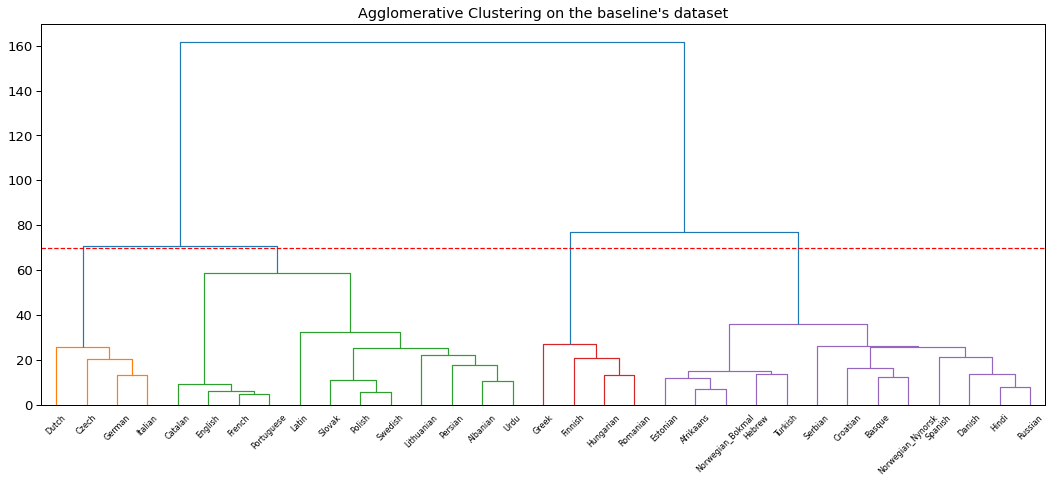

In [100]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance

def do_cluster_hierh(K):
    #X = test_effect.pivot_table(index='language', columns='task')
    Y = pd.DataFrame(test_effect.pivot_table(index='language', columns='task').to_records())
    for col in Y:
        if Y[col].count() <30:
            Y = Y.drop(col, axis=1)
    X=Y.pivot_table(index="language")
    X = X.fillna(X.mean())
    k = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')  
    k.fit(X)
    
    plt.figure(figsize=(18, 7))  
    plt.title("Agglomerative Clustering on the baseline's dataset")  
    dend = shc.dendrogram(shc.linkage(X, method='ward'), labels=X.index, color_threshold=70)

    plt.axhline(y=70, color='r', linestyle='--')

    clusters = [[] for _ in range(K)]
    for i, lab in enumerate(k.labels_):
        clusters[lab].append(X.index[i])
    print(f"K = {K}")
    print("\n------\n".join(", ".join(cl) for cl in clusters))

do_cluster_hierh(4)
#false_similarity_example = pd.DataFrame(X.query('language == ["Czech","German", "Dutch"]').to_records())
#df1 = false_similarity_example.drop(['language'], axis=1).to_numpy()
#false_similarity_example

#dst_cz_nl = distance.euclidean(df1[0], df1[2])
#dst_nl_d = distance.euclidean(df1[1], df1[2])
#dst_cz_d = distance.euclidean(df1[0], df1[1])

#print(f"Cz - Nl {dst_cz_nl} \n Nl - D {dst_nl_d} \n CZ - D {dst_cz_d}")
#test_effect.pivot_table(index='language', columns='task')

In [47]:
def reduce_columns(test_f):
    
    Y = pd.DataFrame(test_f.pivot_table(index='language', columns='task').to_records())
    for col in Y:
        if Y[col].count() <30:
            Y = Y.drop(col, axis=1)
    Y = Y.fillna(Y.mean())
    return Y.pivot_table(index='language')

In [48]:
cooc = defaultdict(lambda: defaultdict(int))

def increase_cooc(langs):
    for l1 in langs:
        for l2 in langs:
            cooc[l1][l2] += 1
            
for _ in range(100):
    K = np.random.randint(5, 11)
    X = reduce_columns(test_effect)
    X = X.fillna(X.mean())
    k = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')  
    k.fit(X)
    cl = pd.DataFrame({'language': X.index, 'cluster':k.labels_})
    cl.groupby('cluster').language.apply(increase_cooc)

<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will rai

<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will rai

<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will rai

<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())
<ipython-input-47-d1b02aba9242>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will rai

In [46]:
    Y = pd.DataFrame(test_effect.pivot_table(index='language', columns='task').to_records())
    for col in Y:
        if Y[col].count() <30:
            Y = Y.drop(col, axis=1)
    Y = Y.fillna(Y.mean())
    Y.pivot_table(index='language')

<ipython-input-46-2700cea50a50>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Y = Y.fillna(Y.mean())


,"('B$_2$', 'number_noun')","('L$_2$', 'number_noun')","('R$_2$', 'number_noun')","('TARG', 'number_noun')","('mBERT-char', 'number_noun')","('mBERT-emb', 'number_noun')","('mBERT-nocontext', 'number_noun')","('mBERT-rand-char', 'number_noun')","('mBERT-rand-subw', 'number_noun')","('next', 'number_noun')","('permute', 'number_noun')","('prev', 'number_noun')"
language,,,,,,,,,,,,
Afrikaans,-0.211082,-0.527704,0.422164,25.751979,3.957784,2.058047,1.846966,45.646438,46.174142,9.762533,0.527704,3.430079
Albanian,2.432432,2.324324,1.675676,13.891892,1.081081,7.027027,4.864865,14.054054,14.594595,7.027027,4.270270,6.378378
Arabic,2.522284,1.324557,0.475737,16.355104,6.789293,6.814119,4.681521,30.641480,32.900646,5.532935,3.364160,3.340437
Armenian,2.522284,1.324557,0.475737,16.355104,6.789293,6.814119,4.681521,30.641480,32.900646,5.532935,3.364160,3.340437
Basque,3.028664,1.027582,2.109248,22.498648,11.844240,5.191996,4.272580,52.947539,42.130882,5.354246,2.920498,3.082747
Bulgarian,2.522284,1.324557,0.475737,16.355104,6.789293,6.814119,4.681521,30.641480,32.900646,5.532935,3.364160,3.340437
Catalan,-0.050505,0.000000,0.000000,3.787879,1.515152,0.606061,1.010101,1.515152,11.616162,3.535354,-0.101010,2.070707
Croatian,7.485503,2.793885,2.477596,15.023722,14.602003,13.600422,8.803374,54.665261,48.866632,4.059041,9.225092,4.744333
Czech,7.869379,4.282655,2.087794,13.169165,10.064240,15.310493,13.276231,21.841542,48.608137,3.640257,8.725910,2.248394


In [49]:
l = exps[['family', 'language']].drop_duplicates().sort_values(['family', 'language'])
l['code'] = l.language.apply(lambda l: lang2code[l])

In [50]:
e = exps[['language']].drop_duplicates()
e['family'] = e['language'].apply(lambda l: lang2large_family[l])
family_size = e.family.value_counts().sort_index()

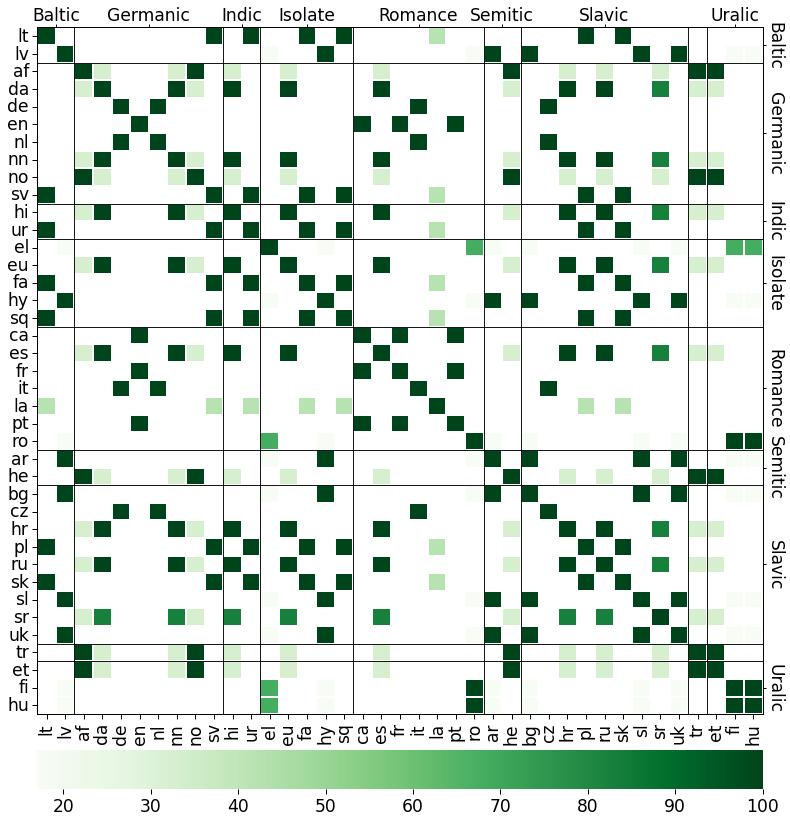

In [51]:
ticklabels = []
ticklocs = []
lang_family = exps[['language']].drop_duplicates()
lang_family['family'] = lang_family['language'].apply(lambda l: lang2large_family[l])
lang_family['code'] = lang_family['language'].apply(lambda l: lang2code[l])
family_size = lang_family.family.value_counts().sort_index()
for fi, (family, size) in enumerate(family_size.items()):
    if size > 1:
        ticklabels.append(family)
        start = family_size.iloc[:fi].sum()
        if fi < len(e) - 1:
            end = family_size.iloc[:fi+1].sum()
        else:
            end = family_size.sum()
        loc = (start+end) / 2
        ticklocs.append(loc)
        
lang_order = lang_family.sort_values(['family', 'code'])
with sns.plotting_context('paper', font_scale=1.95):
    grid_kws = {"height_ratios": (.9, .05), "hspace": .1}
    fig, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(13, 14))
    data = pd.DataFrame(cooc).loc[lang_order.language][lang_order.language]
    data.columns = [lang2code[c] for c in data.columns]
    data.index = [lang2code[c] for c in data.index]
    sns.heatmap(data, ax=ax, cmap='Greens', cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, linewidths=.1)
    for f in np.cumsum(family_size)[:-1]:
        ax.plot((f, f), (0, data.shape[0]), c='black', linewidth=.9)
        ax.plot((0, data.shape[1]), (f, f), c='black', linewidth=.9)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    ax2 = ax.twiny()
    ax2.set_xticks(ticklocs)
    ax2.set_xticklabels(ticklabels)
    ax2.tick_params(axis='x', which='major', pad=0, length=3)
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xlim(ax.get_xlim())
    
    ax3 = ax.twinx()
    ax3.set_yticks(ticklocs)
    ax3.set_yticklabels(ticklabels, va='center')
    ax3.tick_params(axis='y', rotation=-90, which='major', pad=0, length=3)
    ax3.yaxis.set_ticks_position('right')
    ax3.set_ylim(ax.get_ylim())
    
    fig.savefig(f"{figure_dir}/heatmap_langlang_cluster_cooc.png")